In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [133]:
# Load in data
synapsida = pd.read_csv('points_Synapsida_niche.csv', sep=';')
reptilia = pd.read_csv('Reptilia_PT_ed_genus_fullmeta.csv')
    

## Synapsida Data Exploration + Filter

In [134]:
synapsida.head()

,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability
0,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
1,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
2,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
3,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
4,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761


In [135]:
synapsida.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   accepted_name       1340 non-null   object 
 1   accepted_rank       1340 non-null   object 
 2   early_interval      1340 non-null   object 
 3   late_interval       425 non-null    object 
 4   max_ma              1340 non-null   float64
 5   min_ma              1340 non-null   float64
 6   time_bins           1340 non-null   object 
 7   age                 1340 non-null   int64  
 8   Rotated Longitude   1340 non-null   float64
 9   Rotated latitude    1340 non-null   float64
 10  group               1340 non-null   object 
 11  niche_adequability  1327 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 125.8+ KB


In [136]:
synapsida.describe()

,max_ma,min_ma,age,Rotated Longitude,Rotated latitude,niche_adequability
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1327.000000
mean,254.628901,246.955666,250.077612,-43.590576,-5.111178,0.161312
std,10.706562,13.839763,11.585379,34.431085,26.088152,0.195572
min,215.560000,201.300000,215.000000,-76.786580,-50.240640,0.015022
25%,252.170000,247.200000,250.000000,-62.751640,-19.334250,0.048410
50%,259.510000,252.170000,255.000000,-60.850790,-14.724960,0.053002
75%,259.900000,254.170000,255.000000,-49.043510,0.077961,0.223840
max,298.900000,266.900000,266.000000,61.210970,126.127300,0.832678


In [137]:
# Remove all ranks above genus
synapsida_filtered = synapsida[synapsida['accepted_rank'].str.contains('genus|species', case=False, na=False)]

# Cheecking that that worked
synapsida_filtered[synapsida_filtered['accepted_rank'] =="clade"]

,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability


In [138]:
# Checking for null values
synapsida_filtered.isna().sum()

accepted_name           0
accepted_rank           0
early_interval          0
late_interval         740
max_ma                  0
min_ma                  0
time_bins               0
age                     0
Rotated Longitude       0
Rotated latitude        0
group                   0
niche_adequability      9
dtype: int64

## Reptilia Data Exploration

In [139]:
reptilia.head() 

,occurrence_no,class,family,genus,accepted_name,accepted_rank,age_max,age_min,age_uncer_range,age_median,...,genus.1,image_no,formation.1,stratgroup.1,member.1,collection_no.y,identified_name,identified_rank,identified_no,difference
0,788570,Reptilia,Protorothyrididae,Protorothyris,Protorothyris morani,species,298.9,293.52,5.38,296.21,...,Protorothyris,1656,Washington,Dunkard,Upper Marietta Sandstone,85178,n. gen. Melanothyris n. sp. morani,species,137220,recombined as
1,790486,Reptilia,Protorothyrididae,Protorothyris,Protorothyris archeri,species,298.9,293.52,5.38,296.21,...,Protorothyris,1656,Archer City,Wichita,NaN,79163,n. gen. Protorothyris n. sp. archeri,species,135430,NaN
2,790487,Reptilia,Captorhinidae,Romeria,Romeria prima,species,298.9,293.52,5.38,296.21,...,Romeria,2153,Archer City,Wichita,NaN,79163,Romeria n. sp. primus,species,135431,corrected to
3,1285904,Reptilia,Protorosauridae,Aphelosaurus,Aphelosaurus lutevensis,species,298.9,293.52,5.38,296.21,...,Aphelosaurus,930,Usclas-Saint-Privas,NaN,NaN,171350,n. gen. Aphelosaurus n. sp. lutevensis,species,324123,NaN
4,346294,Reptilia,Bolosauridae,Bolosaurus,Bolosaurus striatus,species,298.9,290.10,8.80,294.50,...,Bolosaurus,677,Nocona,Wichita,NaN,11165,Bolosaurus striatus,species,138029,NaN


In [140]:
reptilia.describe()

,occurrence_no,age_max,age_min,age_uncer_range,age_median,accepted_no.y,collection_no.x,accepted_no.x,ref_pubyr,reference_no.x,...,paleolat,paleolng2,paleolat2,paleolng3,paleolat3,artifacts,environment_basis,image_no,collection_no.y,identified_no
count,3.843000e+03,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,...,3829.000000,3833.000000,3833.000000,405.000000,405.000000,0.0,0.0,3843.000000,3843.000000,3843.000000
mean,9.948668e+05,235.666221,226.844473,8.821749,231.255347,133859.628676,104827.005985,133859.628676,1983.564923,40354.098100,...,11.163729,-3.869079,7.995807,6.466815,21.875210,NaN,NaN,1262.875618,104827.005985,140580.416862
std,3.731749e+05,20.286962,21.757171,6.106269,20.812160,105449.680647,58015.517579,105449.680647,37.798083,21629.983104,...,25.821092,38.565242,27.322811,37.237449,8.815373,NaN,NaN,647.423173,58015.517579,106731.174958
min,1.460840e+05,201.400000,199.500000,0.702000,200.450000,36324.000000,11165.000000,36324.000000,1834.000000,4113.000000,...,-82.360000,-72.230000,-82.090000,-44.760000,13.680000,NaN,NaN,11.000000,11165.000000,36324.000000
25%,7.811505e+05,227.000000,208.500000,4.700000,217.750000,64679.000000,56089.000000,64679.000000,1975.000000,26907.000000,...,9.880000,-35.310000,7.660000,-11.880000,15.380000,NaN,NaN,680.000000,56089.000000,64940.000000
50%,9.163880e+05,237.000000,227.000000,7.100000,232.000000,85793.000000,93085.000000,85793.000000,1995.000000,33808.000000,...,16.880000,-2.240000,13.110000,-5.640000,17.310000,NaN,NaN,1442.000000,93085.000000,95793.000000
75%,1.380873e+06,247.200000,242.000000,10.490000,244.600000,169953.000000,139202.000000,169953.000000,2007.000000,62791.000000,...,28.940000,17.720000,23.320000,21.950000,27.610000,NaN,NaN,1968.000000,139202.000000,171751.000000
max,1.660033e+06,298.900000,293.520000,18.500000,296.210000,494698.000000,235534.000000,494698.000000,2024.000000,88919.000000,...,64.490000,139.550000,65.980000,118.870000,44.150000,NaN,NaN,2215.000000,235534.000000,494698.000000


In [141]:
reptilia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Columns: 127 entries, occurrence_no to difference
dtypes: float64(16), int64(9), object(102)
memory usage: 3.7+ MB


In [142]:
reptilia.isna().sum()

occurrence_no         0
class                 0
family                0
genus                 0
accepted_name         0
                   ... 
collection_no.y       0
identified_name       0
identified_rank       0
identified_no         0
difference         2989
Length: 127, dtype: int64

## Imputing Nulls In Interval and Niche

In [143]:
# SYNAPSIDA

# Imputing empty 'late_interval' values with the 'early_interval' value to remove empty cells
synapsida_filtered['late_interval'] = synapsida_filtered['late_interval'].fillna(synapsida_filtered['early_interval'])

# Checking that that worked
synapsida_filtered.isna().sum()

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_22812\929413865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapsida_filtered['late_interval'] = synapsida_filtered['late_interval'].fillna(synapsida_filtered['early_interval'])


accepted_name         0
accepted_rank         0
early_interval        0
late_interval         0
max_ma                0
min_ma                0
time_bins             0
age                   0
Rotated Longitude     0
Rotated latitude      0
group                 0
niche_adequability    9
dtype: int64

In [144]:
# Dropping rows with nulls in niche_adequability for now (until Arielli is done!)
synapsida_filtered.dropna(subset=['niche_adequability'], inplace=True)

# Checking that that worked
synapsida_filtered.isna().sum()

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_22812\3899452644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapsida_filtered.dropna(subset=['niche_adequability'], inplace=True)


accepted_name         0
accepted_rank         0
early_interval        0
late_interval         0
max_ma                0
min_ma                0
time_bins             0
age                   0
Rotated Longitude     0
Rotated latitude      0
group                 0
niche_adequability    0
dtype: int64

In [145]:
synapsida_filtered.describe()

,max_ma,min_ma,age,Rotated Longitude,Rotated latitude,niche_adequability
count,1104.000000,1104.00000,1104.000000,1104.000000,1104.000000,1104.000000
mean,255.498350,248.07952,251.014493,-45.668762,-5.853830,0.149639
std,9.808756,12.66749,10.657180,33.434650,22.615332,0.192048
min,215.560000,201.30000,215.000000,-76.786580,-50.240640,0.015022
25%,252.170000,247.20000,250.000000,-62.751640,-19.334250,0.048410
50%,259.510000,252.17000,255.000000,-60.850790,-14.724960,0.048737
75%,259.900000,254.17000,255.000000,-49.980750,0.077961,0.124715
max,298.900000,266.90000,265.000000,61.210970,81.605770,0.802404


In [146]:
synapsida_filtered.head()

,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability
0,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
1,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
2,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
3,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761
4,Abajudon kaayai,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761


In [147]:
# REPTILIA

# Imputing empty 'late_interval' values with the 'early_interval' value to remove empty cells
reptilia['late_interval'] = reptilia['late_interval'].fillna(reptilia['early_interval'])

# Checking that that worked
reptilia.isna().sum()

occurrence_no         0
class                 0
family                0
genus                 0
accepted_name         0
                   ... 
collection_no.y       0
identified_name       0
identified_rank       0
identified_no         0
difference         2989
Length: 127, dtype: int64

In [148]:
# Seeing if there are non zero nulls
reptilia_nulls = reptilia.isna().sum()
reptilia_nulls[reptilia_nulls >0]

abund_value            1428
abund_unit             1428
occurrence_comments    1414
collection_subset      3822
collection_aka         1879
                       ... 
reinforcement          3744
formation.1             531
stratgroup.1           1963
member.1               2461
difference             2989
Length: 87, dtype: int64

In [149]:
# Seeing if there are non zero nulls
synapsida_filtered_nulls = synapsida_filtered.isna().sum()
synapsida_filtered_nulls[synapsida_filtered_nulls >0]

Series([], dtype: int64)

## Genus-Species Split

In [150]:
# Splitting the 'accepted_rank' column into genus and species columns (if available) 

# Create a new column 'species' filled with empty strings
synapsida_filtered_split = synapsida_filtered
synapsida_filtered_split['species'] = ''

# Loop through each row in the dataframe
for index, row in synapsida_filtered_split.iterrows():
    # Split the 'names' value into words
    accepted_name_split = row['accepted_name'].split()
    
    # If there are two words, update 'names' and 'name 2'
    if len(accepted_name_split) == 2:
        synapsida_filtered_split.at[index, 'accepted_name'] = accepted_name_split[0]
        synapsida_filtered_split.at[index, 'species'] = accepted_name_split[1]

synapsida_filtered_split.head()

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_22812\243303589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapsida_filtered_split['species'] = ''


,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability,species
0,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai
1,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai
2,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai
3,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai
4,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai


In [151]:
synapsida_filtered_split.isna().sum()

accepted_name         0
accepted_rank         0
early_interval        0
late_interval         0
max_ma                0
min_ma                0
time_bins             0
age                   0
Rotated Longitude     0
Rotated latitude      0
group                 0
niche_adequability    0
species               0
dtype: int64

In [152]:
# There are 251 unique genera in the synapsida dataset

synapsida_filtered_split['accepted_name'].value_counts()

Lystrosaurus      69
Diictodon         68
Theriognathus     53
Cistecephalus     44
Pristerodon       40
                  ..
Cyniscops          1
Sauroctonus        1
Brachyprosopus     1
Ictidognathus      1
Pentasaurus        1
Name: accepted_name, Length: 251, dtype: int64

In [153]:
# There are 266 unique species in the reptilia dataset

synapsida_filtered_split['species'].value_counts()

                 143
microps           52
feliceps          48
microrhinus       41
kitchingi         32
                ... 
constrictus        1
diastematicus      1
microdenta         1
masyutinae         1
goggai             1
Name: species, Length: 266, dtype: int64

In [154]:
synapsida2 = synapsida_filtered_split

In [155]:
# Splitting the 'accepted_rank' column into genus and species columns (if available) 

# Create a new column 'species' filled with empty strings
reptilia_split = reptilia
reptilia_split['species'] = ''

# Loop through each row in the dataframe
for index, row in reptilia_split.iterrows():
    # Split the 'names' value into words
    accepted_name_split = row['accepted_name'].split()
    
    # If there are two words, update 'names' and 'name 2'
    if len(accepted_name_split) == 2:
        reptilia_split.at[index, 'species'] = accepted_name_split[1]

reptilia_split.head()

,occurrence_no,class,family,genus,accepted_name,accepted_rank,age_max,age_min,age_uncer_range,age_median,...,image_no,formation.1,stratgroup.1,member.1,collection_no.y,identified_name,identified_rank,identified_no,difference,species
0,788570,Reptilia,Protorothyrididae,Protorothyris,Protorothyris morani,species,298.9,293.52,5.38,296.21,...,1656,Washington,Dunkard,Upper Marietta Sandstone,85178,n. gen. Melanothyris n. sp. morani,species,137220,recombined as,morani
1,790486,Reptilia,Protorothyrididae,Protorothyris,Protorothyris archeri,species,298.9,293.52,5.38,296.21,...,1656,Archer City,Wichita,NaN,79163,n. gen. Protorothyris n. sp. archeri,species,135430,NaN,archeri
2,790487,Reptilia,Captorhinidae,Romeria,Romeria prima,species,298.9,293.52,5.38,296.21,...,2153,Archer City,Wichita,NaN,79163,Romeria n. sp. primus,species,135431,corrected to,prima
3,1285904,Reptilia,Protorosauridae,Aphelosaurus,Aphelosaurus lutevensis,species,298.9,293.52,5.38,296.21,...,930,Usclas-Saint-Privas,NaN,NaN,171350,n. gen. Aphelosaurus n. sp. lutevensis,species,324123,NaN,lutevensis
4,346294,Reptilia,Bolosauridae,Bolosaurus,Bolosaurus striatus,species,298.9,290.10,8.80,294.50,...,677,Nocona,Wichita,NaN,11165,Bolosaurus striatus,species,138029,NaN,striatus


In [156]:
# There are 738 unique genera in the reptilia dataset

reptilia_split['genus'].value_counts()

Grallator           209
Chirotherium        125
Rhynchosauroides    117
Eubrontes           106
Nothosaurus         101
                   ... 
Trichristolopus       1
Eretmorhipis          1
Wimanius              1
Besanosaurus          1
Wintonopus            1
Name: genus, Length: 738, dtype: int64

In [157]:
# There are 924 unique species in the reptilia dataset
reptilia_split['species'].value_counts()

              1186
coccinarum      78
giganteus       62
barthii         44
tuberosus       43
              ... 
piscosus         1
tirolicus        1
schinzi          1
rubeli           1
thiuda           1
Name: species, Length: 924, dtype: int64

## Ages EDA
Finding median, min, and max for max_ma, min_ma
Creating mean_ma column for middle of each occurrence's age range
Then plotting max_ma, min_ma, mean_ma distributions

In [158]:
synapsida2.describe()   

,max_ma,min_ma,age,Rotated Longitude,Rotated latitude,niche_adequability
count,1104.000000,1104.00000,1104.000000,1104.000000,1104.000000,1104.000000
mean,255.498350,248.07952,251.014493,-45.668762,-5.853830,0.149639
std,9.808756,12.66749,10.657180,33.434650,22.615332,0.192048
min,215.560000,201.30000,215.000000,-76.786580,-50.240640,0.015022
25%,252.170000,247.20000,250.000000,-62.751640,-19.334250,0.048410
50%,259.510000,252.17000,255.000000,-60.850790,-14.724960,0.048737
75%,259.900000,254.17000,255.000000,-49.980750,0.077961,0.124715
max,298.900000,266.90000,265.000000,61.210970,81.605770,0.802404


In [159]:
# Creating mean age values column for each row
synapsida2['age_median'] = (synapsida2['max_ma'] + synapsida2['min_ma']) / 2
synapsida2.head()

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_22812\2335623023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapsida2['age_median'] = (synapsida2['max_ma'] + synapsida2['min_ma']) / 2


,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability,species,age_median
0,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35
1,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35
2,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35
3,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35
4,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35


In [160]:
lad_frequency = synapsida2['min_ma'].value_counts()
fad_frequency = synapsida2['max_ma'].value_counts()
print(lad_frequency)
print(fad_frequency)

254.170    261
254.140    156
251.902    150
252.170    117
247.200     94
237.000     68
228.000     61
208.500     55
252.300     32
259.510     25
251.200     21
264.280     13
259.900     10
256.800     10
265.000     10
201.300      9
266.900      5
265.100      2
212.000      2
235.000      1
232.000      1
221.500      1
Name: min_ma, dtype: int64
259.900    360
259.510    316
252.170     95
242.000     73
237.000     61
228.000     48
268.000     34
264.280     21
254.170     17
266.900     16
251.200     15
247.200     12
268.800     10
273.010      7
259.000      4
251.902      4
276.500      4
272.300      2
215.560      2
298.900      1
235.000      1
232.000      1
Name: max_ma, dtype: int64


In [161]:
reptilia_split.describe()

,occurrence_no,age_max,age_min,age_uncer_range,age_median,accepted_no.y,collection_no.x,accepted_no.x,ref_pubyr,reference_no.x,...,paleolat,paleolng2,paleolat2,paleolng3,paleolat3,artifacts,environment_basis,image_no,collection_no.y,identified_no
count,3.843000e+03,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,...,3829.000000,3833.000000,3833.000000,405.000000,405.000000,0.0,0.0,3843.000000,3843.000000,3843.000000
mean,9.948668e+05,235.666221,226.844473,8.821749,231.255347,133859.628676,104827.005985,133859.628676,1983.564923,40354.098100,...,11.163729,-3.869079,7.995807,6.466815,21.875210,NaN,NaN,1262.875618,104827.005985,140580.416862
std,3.731749e+05,20.286962,21.757171,6.106269,20.812160,105449.680647,58015.517579,105449.680647,37.798083,21629.983104,...,25.821092,38.565242,27.322811,37.237449,8.815373,NaN,NaN,647.423173,58015.517579,106731.174958
min,1.460840e+05,201.400000,199.500000,0.702000,200.450000,36324.000000,11165.000000,36324.000000,1834.000000,4113.000000,...,-82.360000,-72.230000,-82.090000,-44.760000,13.680000,NaN,NaN,11.000000,11165.000000,36324.000000
25%,7.811505e+05,227.000000,208.500000,4.700000,217.750000,64679.000000,56089.000000,64679.000000,1975.000000,26907.000000,...,9.880000,-35.310000,7.660000,-11.880000,15.380000,NaN,NaN,680.000000,56089.000000,64940.000000
50%,9.163880e+05,237.000000,227.000000,7.100000,232.000000,85793.000000,93085.000000,85793.000000,1995.000000,33808.000000,...,16.880000,-2.240000,13.110000,-5.640000,17.310000,NaN,NaN,1442.000000,93085.000000,95793.000000
75%,1.380873e+06,247.200000,242.000000,10.490000,244.600000,169953.000000,139202.000000,169953.000000,2007.000000,62791.000000,...,28.940000,17.720000,23.320000,21.950000,27.610000,NaN,NaN,1968.000000,139202.000000,171751.000000
max,1.660033e+06,298.900000,293.520000,18.500000,296.210000,494698.000000,235534.000000,494698.000000,2024.000000,88919.000000,...,64.490000,139.550000,65.980000,118.870000,44.150000,NaN,NaN,2215.000000,235534.000000,494698.000000


In [162]:
# Change reptilia names to match what pyrate_utilities.r package (PyRate.py input file creation) expects
reptilia_split = reptilia_split.drop(columns='accepted_name')
reptilia2 = reptilia_split.rename(columns={'age_max':'max_ma', 'age_min':'min_ma', 'genus':'accepted_name'})
reptilia2.head()

,occurrence_no,class,family,accepted_name,accepted_rank,max_ma,min_ma,age_uncer_range,age_median,accepted_no.y,...,image_no,formation.1,stratgroup.1,member.1,collection_no.y,identified_name,identified_rank,identified_no,difference,species
0,788570,Reptilia,Protorothyrididae,Protorothyris,species,298.9,293.52,5.38,296.21,137220,...,1656,Washington,Dunkard,Upper Marietta Sandstone,85178,n. gen. Melanothyris n. sp. morani,species,137220,recombined as,morani
1,790486,Reptilia,Protorothyrididae,Protorothyris,species,298.9,293.52,5.38,296.21,135430,...,1656,Archer City,Wichita,NaN,79163,n. gen. Protorothyris n. sp. archeri,species,135430,NaN,archeri
2,790487,Reptilia,Captorhinidae,Romeria,species,298.9,293.52,5.38,296.21,135431,...,2153,Archer City,Wichita,NaN,79163,Romeria n. sp. primus,species,135431,corrected to,prima
3,1285904,Reptilia,Protorosauridae,Aphelosaurus,species,298.9,293.52,5.38,296.21,324123,...,930,Usclas-Saint-Privas,NaN,NaN,171350,n. gen. Aphelosaurus n. sp. lutevensis,species,324123,NaN,lutevensis
4,346294,Reptilia,Bolosauridae,Bolosaurus,species,298.9,290.10,8.80,294.50,138029,...,677,Nocona,Wichita,NaN,11165,Bolosaurus striatus,species,138029,NaN,striatus


In [163]:
# Creating an age range column for synapsida
synapsida2['age_uncer_range'] = synapsida2['max_ma'] - synapsida2['min_ma']
synapsida2.head()

C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_22812\2007848900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synapsida2['age_uncer_range'] = synapsida2['max_ma'] - synapsida2['min_ma']


,accepted_name,accepted_rank,early_interval,late_interval,max_ma,min_ma,time_bins,age,Rotated Longitude,Rotated latitude,group,niche_adequability,species,age_median,age_uncer_range
0,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35,8.9
1,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35,8.9
2,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35,8.9
3,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35,8.9
4,Abajudon,species,Wordian,Capitanian,268.8,259.9,Wordian,265,-56.95375,-1.203179,Dicynodontia,0.209761,kaayai,264.35,8.9


In [164]:
reptilia2.head()

,occurrence_no,class,family,accepted_name,accepted_rank,max_ma,min_ma,age_uncer_range,age_median,accepted_no.y,...,image_no,formation.1,stratgroup.1,member.1,collection_no.y,identified_name,identified_rank,identified_no,difference,species
0,788570,Reptilia,Protorothyrididae,Protorothyris,species,298.9,293.52,5.38,296.21,137220,...,1656,Washington,Dunkard,Upper Marietta Sandstone,85178,n. gen. Melanothyris n. sp. morani,species,137220,recombined as,morani
1,790486,Reptilia,Protorothyrididae,Protorothyris,species,298.9,293.52,5.38,296.21,135430,...,1656,Archer City,Wichita,NaN,79163,n. gen. Protorothyris n. sp. archeri,species,135430,NaN,archeri
2,790487,Reptilia,Captorhinidae,Romeria,species,298.9,293.52,5.38,296.21,135431,...,2153,Archer City,Wichita,NaN,79163,Romeria n. sp. primus,species,135431,corrected to,prima
3,1285904,Reptilia,Protorosauridae,Aphelosaurus,species,298.9,293.52,5.38,296.21,324123,...,930,Usclas-Saint-Privas,NaN,NaN,171350,n. gen. Aphelosaurus n. sp. lutevensis,species,324123,NaN,lutevensis
4,346294,Reptilia,Bolosauridae,Bolosaurus,species,298.9,290.10,8.80,294.50,138029,...,677,Nocona,Wichita,NaN,11165,Bolosaurus striatus,species,138029,NaN,striatus


## Changing Data Type + Filtering Columns

In [165]:
# Info is too long to show, but 'geoplate' column is 'object' instead of numeric
reptilia2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Columns: 127 entries, occurrence_no to species
dtypes: float64(16), int64(9), object(102)
memory usage: 3.7+ MB


In [166]:
# geoplate needs to be made into floats
reptilia2['geoplate'] = pd.to_numeric(reptilia2['geoplate'], errors='coerce')
reptilia2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Columns: 127 entries, occurrence_no to species
dtypes: float64(17), int64(9), object(101)
memory usage: 3.7+ MB


In [167]:
# Filtering to just columns needed for predictors
reptilia_filtered = reptilia2[['accepted_name', 'min_ma', 'max_ma', 'family', 'time_bins', 'taxon_environment', 'geoplate', 'paleolng', 'paleolat']].copy()
reptilia_filtered.head()

,accepted_name,min_ma,max_ma,family,time_bins,taxon_environment,geoplate,paleolng,paleolat
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-14.53,-3.08
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-30.65,-2.02
2,Romeria,293.52,298.9,Captorhinidae,Asselian,terrestrial,101.0,-30.65,-2.02
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,terrestrial,305.0,18.10,-1.36
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,terrestrial,101.0,-30.37,-1.69


## OHE Categorical Columns

In [168]:
reptilia_ohe = reptilia_filtered.copy()
reptilia_ohe['terrestrial'] = 0

# Assigning a 1 to terrestrial if the taxon_environment column contains 'terrestrial'
reptilia_ohe.loc[reptilia_ohe['taxon_environment'].str.contains('terrestrial', case=False, na=False), 'terrestrial'] = 1

reptilia_ohe.head()

,accepted_name,min_ma,max_ma,family,time_bins,taxon_environment,geoplate,paleolng,paleolat,terrestrial
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-14.53,-3.08,1
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-30.65,-2.02,1
2,Romeria,293.52,298.9,Captorhinidae,Asselian,terrestrial,101.0,-30.65,-2.02,1
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,terrestrial,305.0,18.10,-1.36,1
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,terrestrial,101.0,-30.37,-1.69,1


In [169]:
# Finding where taxon_environment is a comma-separated string
reptilia_filtered[reptilia_filtered['taxon_environment'].str.contains(',', na=False)]

,accepted_name,min_ma,max_ma,family,time_bins,taxon_environment,geoplate,paleolng,paleolat
9,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
10,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
11,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
12,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
27,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-43.60,-63.28
28,Brazilosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-29.20,-38.70
29,Stereosternum,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-29.20,-38.70
30,Brazilosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17
31,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17
32,Stereosternum,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17


In [170]:
# iloc'ing into reptilia_ohe where reptilia_filtered contained a comma-separated string 'freshwater,terrestrial' to check that 
# the 'terrestrial' column was assigned a 1
reptilia_ohe.iloc[2537]

accepted_name                  Hypuronector
min_ma                                208.5
max_ma                                227.0
family                  NO_FAMILY_SPECIFIED
time_bins                            Norian
taxon_environment    freshwater,terrestrial
geoplate                              101.0
paleolng                              -8.55
paleolat                              14.34
terrestrial                               1
Name: 2537, dtype: object

In [171]:
reptilia_ohe.drop('taxon_environment', axis=1, inplace=True)
reptilia_ohe.head()

,accepted_name,min_ma,max_ma,family,time_bins,geoplate,paleolng,paleolat,terrestrial
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-14.53,-3.08,1
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-30.65,-2.02,1
2,Romeria,293.52,298.9,Captorhinidae,Asselian,101.0,-30.65,-2.02,1
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,305.0,18.10,-1.36,1
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,101.0,-30.37,-1.69,1


In [172]:
reptilia_ohe_final = reptilia_ohe.drop(columns=['family', 'time_bins', 'geoplate', 'paleolng', 'min_ma', 'max_ma'])
reptilia_ohe_final.head()

,accepted_name,paleolat,terrestrial
0,Protorothyris,-3.08,1
1,Protorothyris,-2.02,1
2,Romeria,-2.02,1
3,Aphelosaurus,-1.36,1
4,Bolosaurus,-1.69,1


## Creating Per-Species Predictors

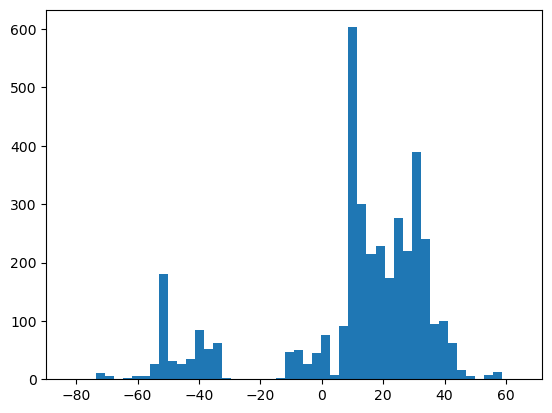

In [173]:
# Viewing the distribution of paleolat values
plt.hist(reptilia_ohe_final['paleolat'], bins=50)
plt.show()

In [174]:
# Checking how many unique species there are (rows) 
reptilia_ohe_per_species = reptilia_ohe_final.groupby('accepted_name').mean().round(1)
reptilia_ohe_per_species

,paleolat,terrestrial
accepted_name,,
Abyssomedon,-0.4,1.0
Acadiella,20.2,1.0
Acaenasuchus,10.2,1.0
Acallosuchus,10.4,1.0
Acerosodontosaurus,-42.9,1.0
...,...,...
Yunguisaurus,-7.4,0.0
Yunnanosaurus,37.7,1.0
Zanclodon,29.7,1.0


In [175]:
# Checking that the number of rows in reptilia_ohe_per_species matches the unique number of species in reptilia_ohe_final
reptilia_ohe_final['accepted_name'].value_counts()

# Matches. Both have 738 rows

Grallator           209
Chirotherium        125
Rhynchosauroides    117
Eubrontes           106
Nothosaurus         101
                   ... 
Trichristolopus       1
Eretmorhipis          1
Wimanius              1
Besanosaurus          1
Wintonopus            1
Name: accepted_name, Length: 738, dtype: int64

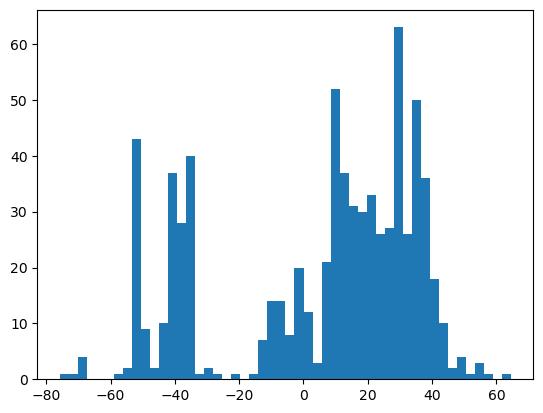

In [176]:
# Viewing the distribution of paleolat values in per-species data
plt.hist(reptilia_ohe_per_species['paleolat'], bins=50)
plt.show()

# Distribution has remained approximately the same, justifying averaging the paleolatitude values per-species across occurrences of that species

## Fixing Paleolat Nulls

In [177]:
# Nulls are in 5 terrestrial species
reptilia_ohe_per_species[reptilia_ohe_per_species.isnull().any(axis=1)]


,paleolat,terrestrial
accepted_name,,
Prolacertoides,NaN,1.0
Santaisaurus,NaN,1.0
Turfanosuchus,NaN,1.0
Youngosuchus,NaN,1.0


In [180]:
# Paleolat column is still an object
reptilia_ohe_per_species.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, Abyssomedon to Zupaysaurus
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   paleolat     734 non-null    float64
 1   terrestrial  738 non-null    float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [179]:
# Changin paleolat to float
reptilia_ohe_per_species['paleolat'] = reptilia_ohe_per_species['paleolat'].astype(float)

In [181]:
# Decided to impute the paleolat nulls with the mean paleolat for all terrestrial species
terrestrial = reptilia_ohe_per_species[reptilia_ohe_per_species['terrestrial'] == 1]
terrestrial['paleolat'].mean()

1.7638983050847419

In [182]:
reptilia_ohe_per_species_imputed = reptilia_ohe_per_species.fillna("1.76")
reptilia_ohe_per_species_imputed[reptilia_ohe_per_species_imputed.isnull().any(axis=1)]


,paleolat,terrestrial
accepted_name,,


## Normalizing Paleolat (Continuous Variable)

In [194]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reptilia_ohe_per_species_imputed['paleolat_normalized'] = scaler.fit_transform(reptilia_ohe_per_species_imputed[['paleolat']]).round(1)
reptilia_ohe_per_species_imputed

,paleolat,terrestrial,paleolat_normalized
accepted_name,,,
Abyssomedon,-0.4,1.0,-0.2
Acadiella,20.2,1.0,0.5
Acaenasuchus,10.2,1.0,0.2
Acallosuchus,10.4,1.0,0.2
Acerosodontosaurus,-42.9,1.0,-1.6
...,...,...,...
Yunguisaurus,-7.4,0.0,-0.4
Yunnanosaurus,37.7,1.0,1.1
Zanclodon,29.7,1.0,0.8


In [195]:
reptilia_final = reptilia_ohe_per_species_imputed.drop('paleolat', axis=1)
reptilia_final

,terrestrial,paleolat_normalized
accepted_name,,
Abyssomedon,1.0,-0.2
Acadiella,1.0,0.5
Acaenasuchus,1.0,0.2
Acallosuchus,1.0,0.2
Acerosodontosaurus,1.0,-1.6
...,...,...
Yunguisaurus,0.0,-0.4
Yunnanosaurus,1.0,1.1
Zanclodon,1.0,0.8


In [199]:
reptilia_final.isna().sum()

terrestrial            0
paleolat_normalized    0
dtype: int64

## DEFUNCT - OHE Categorical Columns

In [106]:
# Outputting value counts for each of the categorical columns minus 'accepted_name'
categoricals = reptilia_filtered.drop('accepted_name', axis=1).select_dtypes(include=['object'])
for col in categoricals:
    print(f'{col}:\n{categoricals[col].value_counts()}\n')

family:
NO_FAMILY_SPECIFIED    1004
Grallatoridae           373
Chirotheriidae          300
Stagonolepididae        228
Parasuchidae            227
                       ... 
Parvinatatoridae          1
Besanosauridae            1
Wimaniidae                1
Poposauridae              1
Leptonectidae             1
Name: family, Length: 121, dtype: int64

time_bins:
Norian           1012
Anisian           706
Hettangian        405
Carnian           363
Olenekian         309
Ladinian          296
Rhaetian          279
Wuchiapingian     144
Capitanian         83
Artinskian         82
Kungurian          62
Roadian            37
Induan             34
Changhsingian      17
Wordian             8
Asselian            5
-                   1
Name: time_bins, dtype: int64

taxon_environment:
terrestrial                3129
marine                      640
coastal,marine,brackish      49
freshwater                   23
freshwater,terrestrial        2
Name: taxon_environment, dtype: int64



In [107]:
reptilia_filtered.head()

,accepted_name,min_ma,max_ma,family,time_bins,taxon_environment,geoplate,paleolng,paleolat
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-14.53,-3.08
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,terrestrial,101.0,-30.65,-2.02
2,Romeria,293.52,298.9,Captorhinidae,Asselian,terrestrial,101.0,-30.65,-2.02
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,terrestrial,305.0,18.10,-1.36
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,terrestrial,101.0,-30.37,-1.69


In [108]:
# Finding where taxon_environment is a comma-separated string
reptilia_filtered[reptilia_filtered['taxon_environment'].str.contains(',', na=False)]

,accepted_name,min_ma,max_ma,family,time_bins,taxon_environment,geoplate,paleolng,paleolat
9,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
10,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
11,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
12,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-32.37,-52.31
27,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",701.0,-43.60,-63.28
28,Brazilosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-29.20,-38.70
29,Stereosternum,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-29.20,-38.70
30,Brazilosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17
31,Mesosaurus,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17
32,Stereosternum,283.5,290.1,Mesosauridae,Artinskian,"coastal,marine,brackish",201.0,-28.58,-39.17


In [109]:
from sklearn.preprocessing import OneHotEncoder

reptilia_ohe1 = reptilia_filtered.copy()

# Instatiate the encoder
ohe = OneHotEncoder(sparse_output=False)

# Fit the encoder to the data, transform data --> array
encoded_columns_array = ohe.fit_transform(reptilia_ohe1[['taxon_environment']])

# Get feature names to later use as columns
columns = ohe.get_feature_names_out(['taxon_environment'])

# Making the array into a DataFrame with feature names as columns
encoded_df = pd.DataFrame(encoded_columns_array, columns=columns).astype(int)

encoded_df.head()

,"taxon_environment_coastal,marine,brackish",taxon_environment_freshwater,"taxon_environment_freshwater,terrestrial",taxon_environment_marine,taxon_environment_terrestrial
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [110]:
# Remove the 'taxon_environment_' from the columns
encoded_df.columns = encoded_df.columns.str.replace('taxon_environment_', '')
encoded_df.head()


,"coastal,marine,brackish",freshwater,"freshwater,terrestrial",marine,terrestrial
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [111]:
reptilia_ohe2 = pd.concat([reptilia_ohe1.drop('taxon_environment', axis=1), encoded_df], axis=1)
reptilia_ohe2.head()

,accepted_name,min_ma,max_ma,family,time_bins,geoplate,paleolng,paleolat,"coastal,marine,brackish",freshwater,"freshwater,terrestrial",marine,terrestrial
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-14.53,-3.08,0,0,0,0,1
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-30.65,-2.02,0,0,0,0,1
2,Romeria,293.52,298.9,Captorhinidae,Asselian,101.0,-30.65,-2.02,0,0,0,0,1
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,305.0,18.10,-1.36,0,0,0,0,1
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,101.0,-30.37,-1.69,0,0,0,0,1


In [112]:
# Checking to make sure that a row that used to have a value of 'coastal,marine,brackish' in the original 'taxon_environment' column
# now has a 1 in the 'coastal,marine,brackish' column
reptilia_ohe2.iloc[67]

# Note that it has a 0 in the 'marine' column. Important for later

accepted_name                Mesosaurus
min_ma                            283.5
max_ma                            290.1
family                     Mesosauridae
time_bins                    Artinskian
geoplate                          202.0
paleolng                          -39.5
paleolat                         -51.15
coastal,marine,brackish               1
freshwater                            0
freshwater,terrestrial                0
marine                                0
terrestrial                           0
Name: 67, dtype: object

In [113]:
reptilia_ohe2.columns

Index(['accepted_name', 'min_ma', 'max_ma', 'family', 'time_bins', 'geoplate',
       'paleolng', 'paleolat', 'coastal,marine,brackish', 'freshwater',
       'freshwater,terrestrial', 'marine', 'terrestrial'],
      dtype='object')

In [114]:
# Creating new columns that separate out the 'coastal,marine,brackish' column and have a 1 for each of the three values if the original column had a 1
reptilia_ohe2['coastal'] = reptilia_ohe2['coastal,marine,brackish']
reptilia_ohe2['brackish'] = reptilia_ohe2['coastal,marine,brackish']
reptilia_ohe2['marine'] = reptilia_ohe2['coastal,marine,brackish'] | reptilia_ohe2['marine']

# Doing the same for 'freshwater,terrestrial' column
reptilia_ohe2['freshwater'] = reptilia_ohe2['freshwater'] | reptilia_ohe2['freshwater,terrestrial']
reptilia_ohe2['terrestrial'] = reptilia_ohe2['freshwater,terrestrial']

# Checking that the values were applied properly by iloc'ing into a row that should have a 1 in the 'coastal', 'marine', and 'brackish' columns
reptilia_ohe2.iloc[67]

accepted_name                Mesosaurus
min_ma                            283.5
max_ma                            290.1
family                     Mesosauridae
time_bins                    Artinskian
geoplate                          202.0
paleolng                          -39.5
paleolat                         -51.15
coastal,marine,brackish               1
freshwater                            0
freshwater,terrestrial                0
marine                                1
terrestrial                           0
coastal                               1
brackish                              1
Name: 67, dtype: object

In [115]:
# Checking that the values were applied properly by iloc'ing into a row that should have a 1 in the 'freshwater,terrestrial' columns
reptilia_ohe2.iloc[2537]

accepted_name                     Hypuronector
min_ma                                   208.5
max_ma                                   227.0
family                     NO_FAMILY_SPECIFIED
time_bins                               Norian
geoplate                                 101.0
paleolng                                 -8.55
paleolat                                 14.34
coastal,marine,brackish                      0
freshwater                                   1
freshwater,terrestrial                       1
marine                                       0
terrestrial                                  1
coastal                                      0
brackish                                     0
Name: 2537, dtype: object

In [116]:
# Dropping the original columns, creating a new dataframe
reptilia_ohe3 = reptilia_ohe2.drop(columns =['coastal,marine,brackish', 'freshwater,terrestrial'])
reptilia_ohe3.head()

,accepted_name,min_ma,max_ma,family,time_bins,geoplate,paleolng,paleolat,freshwater,marine,terrestrial,coastal,brackish
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-14.53,-3.08,0,0,0,0,0
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-30.65,-2.02,0,0,0,0,0
2,Romeria,293.52,298.9,Captorhinidae,Asselian,101.0,-30.65,-2.02,0,0,0,0,0
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,305.0,18.10,-1.36,0,0,0,0,0
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,101.0,-30.37,-1.69,0,0,0,0,0


In [117]:

reptilia_ohe3 = reptilia_ohe2.drop('freshwater,terrestrial', axis=1)
reptilia_ohe3.head()

,accepted_name,min_ma,max_ma,family,time_bins,geoplate,paleolng,paleolat,"coastal,marine,brackish",freshwater,marine,terrestrial,coastal,brackish
0,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-14.53,-3.08,0,0,0,0,0,0
1,Protorothyris,293.52,298.9,Protorothyrididae,Asselian,101.0,-30.65,-2.02,0,0,0,0,0,0
2,Romeria,293.52,298.9,Captorhinidae,Asselian,101.0,-30.65,-2.02,0,0,0,0,0,0
3,Aphelosaurus,293.52,298.9,Protorosauridae,Asselian,305.0,18.10,-1.36,0,0,0,0,0,0
4,Bolosaurus,290.10,298.9,Bolosauridae,Asselian,101.0,-30.37,-1.69,0,0,0,0,0,0


## Save Cleaned Dataframes

In [118]:
# Save full thing
reptilia2.to_csv('Reptilia_cleaned_full.csv', index=False)
synapsida2.to_csv('Synapsida_cleaned_full.csv', index=False)

In [119]:
# Save just the columns we need for PyRate + Predictor columns indicated by Tiago
reptilia_filtered.to_csv('Reptilia_cleaned_preds.csv', index=False)

In [200]:
# Save just the columns we need for trait table (per-species predictors)
reptilia_final.to_csv('Reptilia_ohe_per_species.csv')
reptilia_final.to_csv('Reptilia_ohe_per_species.txt', sep='\t')


In [123]:
# Save just columns needed to create PyRate input file
reptilia2.to_csv('Reptilia_cleaned_pyrate_input.csv', index=False, columns=['accepted_name', 'min_ma', 'max_ma'])
synapsida2.to_csv('Synapsida_cleaned_pyrate_input.csv', index=False, columns=['accepted_name', 'min_ma', 'max_ma'])

## Time Graphs

In [29]:
synapsida2.describe()

,age_max,age_min,age,Rotated Longitude,Rotated latitude,niche_adequability,age_median,age_uncer_range
count,1104.000000,1104.00000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,255.498350,248.07952,251.014493,-45.668762,-5.853830,0.149639,251.788935,7.418830
std,9.808756,12.66749,10.657180,33.434650,22.615332,0.192048,11.070685,4.807676
min,215.560000,201.30000,215.000000,-76.786580,-50.240640,0.015022,213.780000,0.970000
25%,252.170000,247.20000,250.000000,-62.751640,-19.334250,0.048410,249.685000,5.370000
50%,259.510000,252.17000,255.000000,-60.850790,-14.724960,0.048737,256.035000,5.730000
75%,259.900000,254.17000,255.000000,-49.980750,0.077961,0.124715,257.035000,7.730000
max,298.900000,266.90000,265.000000,61.210970,81.605770,0.802404,275.535000,46.730000


In [30]:
# Scatterplot function

def scatter(df, df_name, column_name):
    frequency = df[column_name].value_counts()

    # Create figure and axes objects explicitly
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    
    # Set figure facecolor to white
    fig.patch.set_facecolor('white')    
    
    sns.scatterplot(x=frequency.index, y=frequency.values)
    plt.title(f"Frequency of {df_name} {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")

    # Dynamically determine x_min and x_max
    x_min = math.floor(min(frequency.index))
    x_max = math.ceil(max(frequency.index))

    # Ensure x_min and x_max are multiples of 5
    x_min = x_min - (x_min % 5)
    x_max = x_max + (5 - x_max % 5)

    # Add a horizontal red dashed line at y = 10
    ax.axhline(y=10, color='r', linestyle='--', linewidth=2)

    # Create ticks and labels
    x_ticks = np.arange(x_min, x_max + 1, 1)  # Ticks for every 1
    x_labels = [str(x) if x % 5 == 0 else '' for x in x_ticks]  # Labels for every 5

    plt.xticks(x_ticks, x_labels)
    plt.xlim(x_min, x_max)

    plt.savefig(f'eda_images/{df_name}_{column_name}_scatter.png', dpi=300)
    plt.show()
    plt.close()

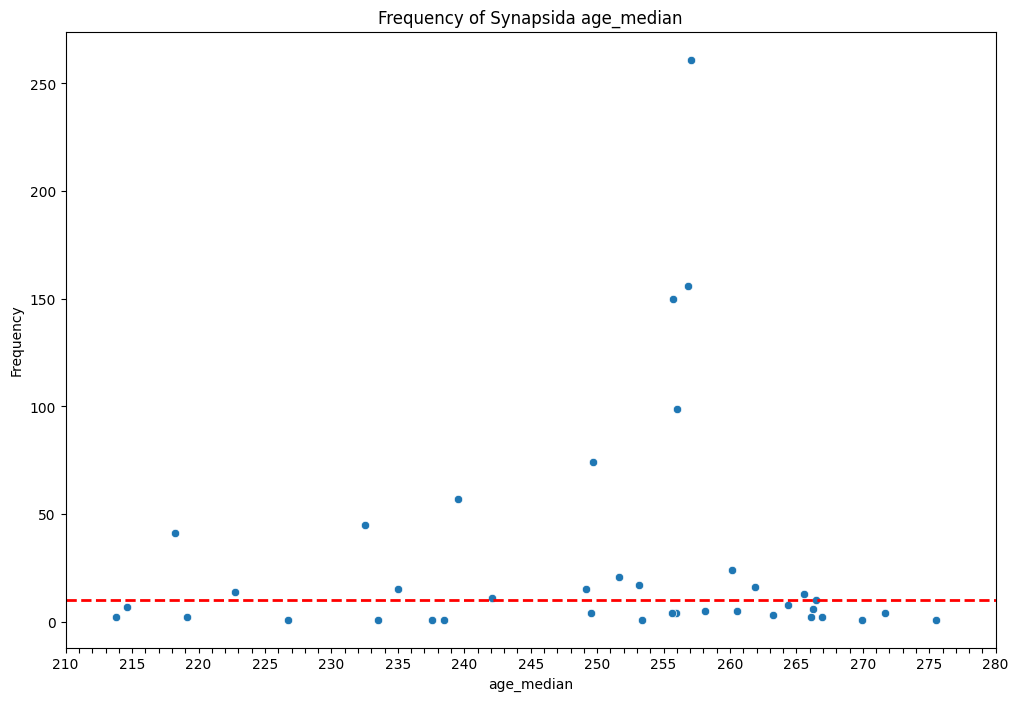

In [31]:
scatter(synapsida2, 'Synapsida', 'age_median')

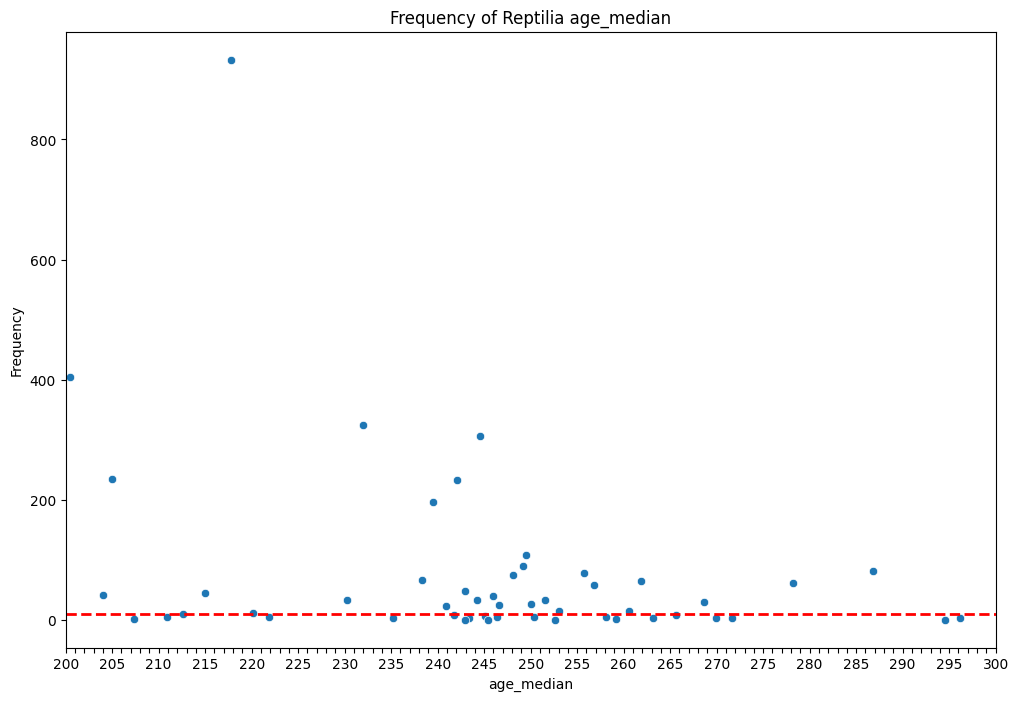

In [32]:
scatter(reptilia2, 'Reptilia', 'age_median')

In [33]:
# Creating custom function for histogram w/ flexible number of bins

def flexible_histogram(df, df_name, column_name, bin_size):
    # Get the data
    data = df[column_name]

    # Create figure and axes objects explicitly
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set figure facecolor to white
    fig.patch.set_facecolor('white')
    
    # Determine the range for the bins
    min_val = bin_size * math.floor(data.min() / bin_size)
    max_val = bin_size * math.ceil(data.max() / bin_size)
    bins = list(range(min_val, max_val + bin_size + 1, bin_size))

    # Plot the histogram
    n, bins, patches = ax.hist(data, bins=bins, edgecolor='black', align='left')
    
    # Add horizontal line at y=10
    ax.axhline(y=10, color='r', linestyle='--', linewidth=2)
    
    # Set title and labels
    ax.set_title(f"Distribution of {df_name} {column_name}", fontsize=16, pad=20)
    ax.set_xlabel(column_name, fontsize=12, labelpad=10)
    ax.set_ylabel("Frequency", fontsize=12, labelpad=10)
    
    # Invert x-axis
    ax.set_xlim(max_val + bin_size, min_val)
    
    # Set x-ticks
    ax.set_xticks(bins[:-1] + bin_size/2)  # Center x-ticks in the middle of each bar
    ax.set_xticklabels([f'{x:.0f}-{x+bin_size-1:.0f}' for x in bins[:-1]], rotation=45, ha='right')


    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Save the figure with a higher dpi and bbox_inches='tight' to include all elements
    plt.savefig(f'eda_images/{df_name}_{column_name}_histogram_bin{bin_size}.png', dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    plt.close()



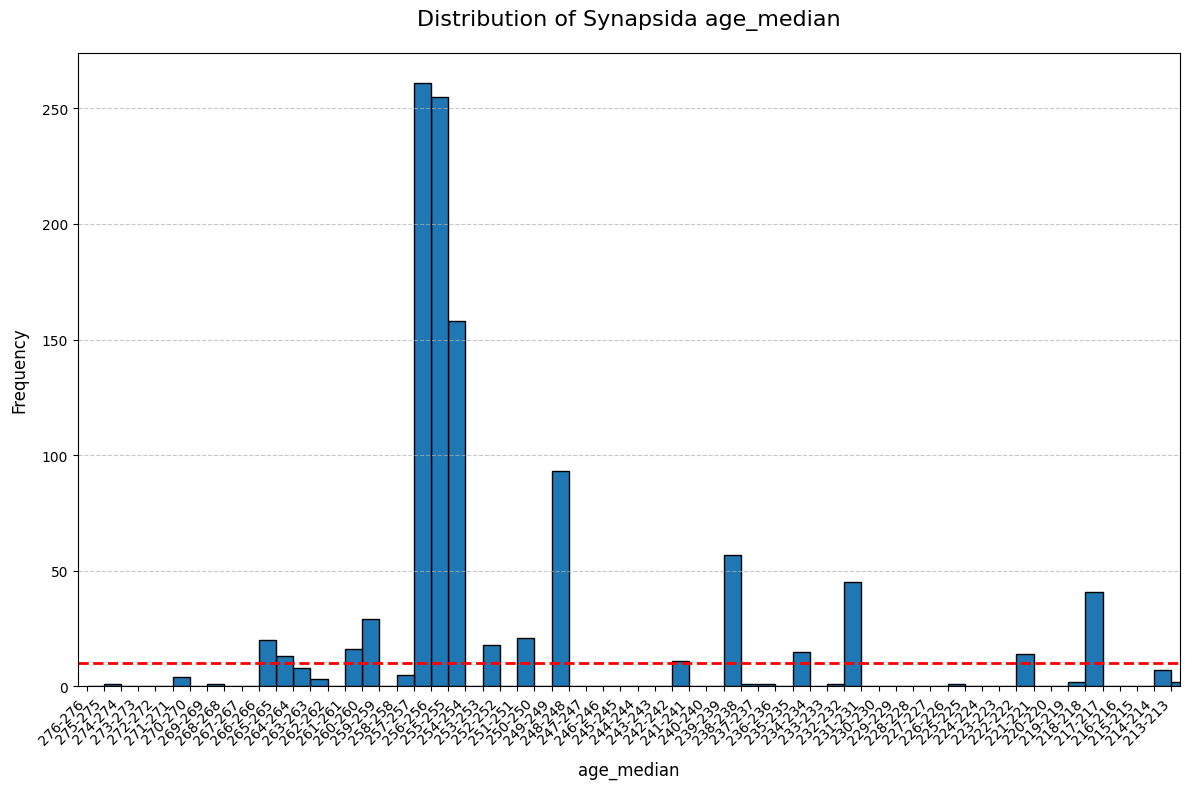

In [34]:
flexible_histogram(synapsida2, 'Synapsida', 'age_median', 1)

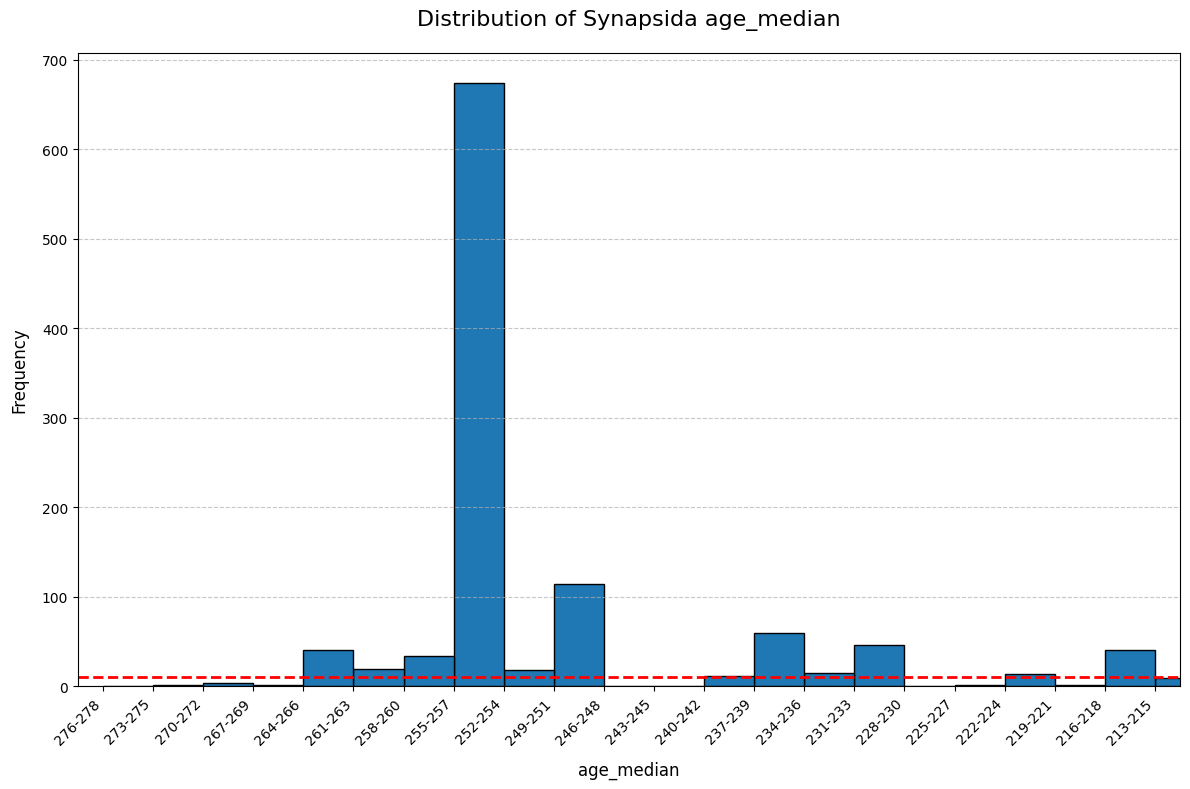

In [35]:
flexible_histogram(synapsida2, 'Synapsida', 'age_median', 3)

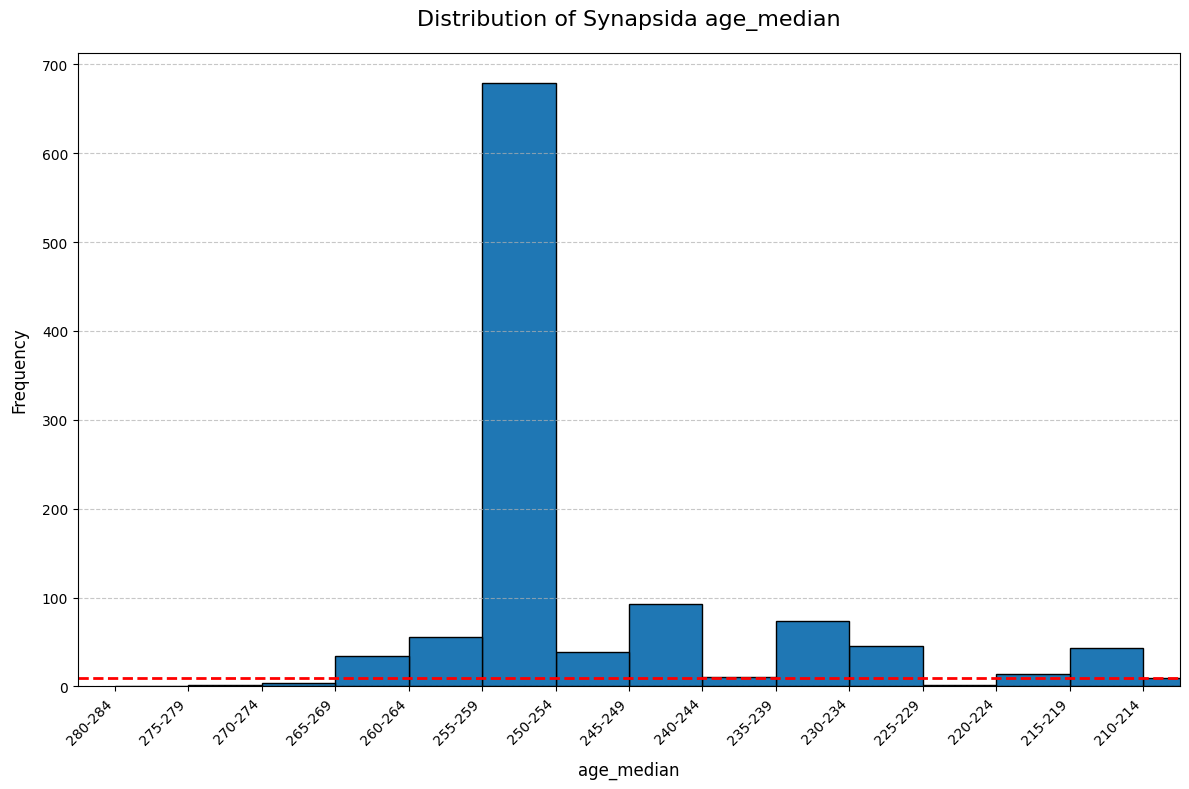

In [36]:
flexible_histogram(synapsida2, 'Synapsida', 'age_median', 5)

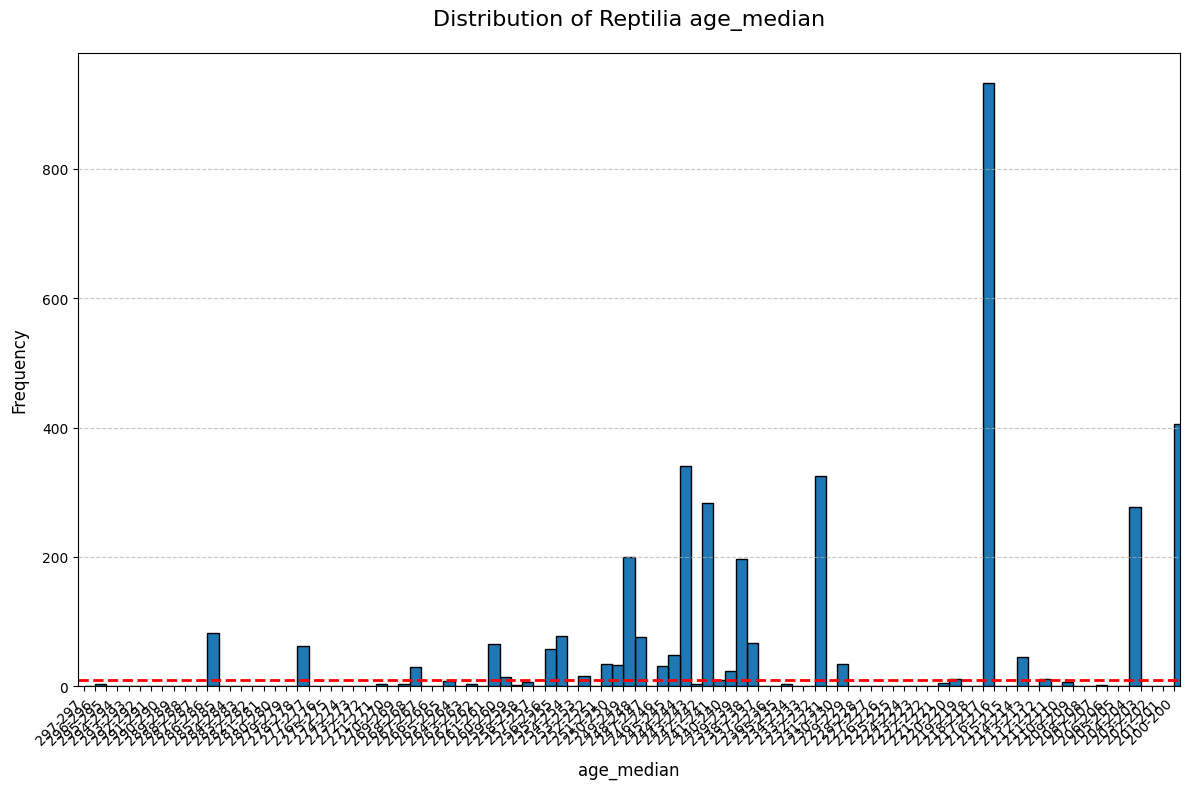

In [37]:
flexible_histogram(reptilia2, 'Reptilia', 'age_median', 1)

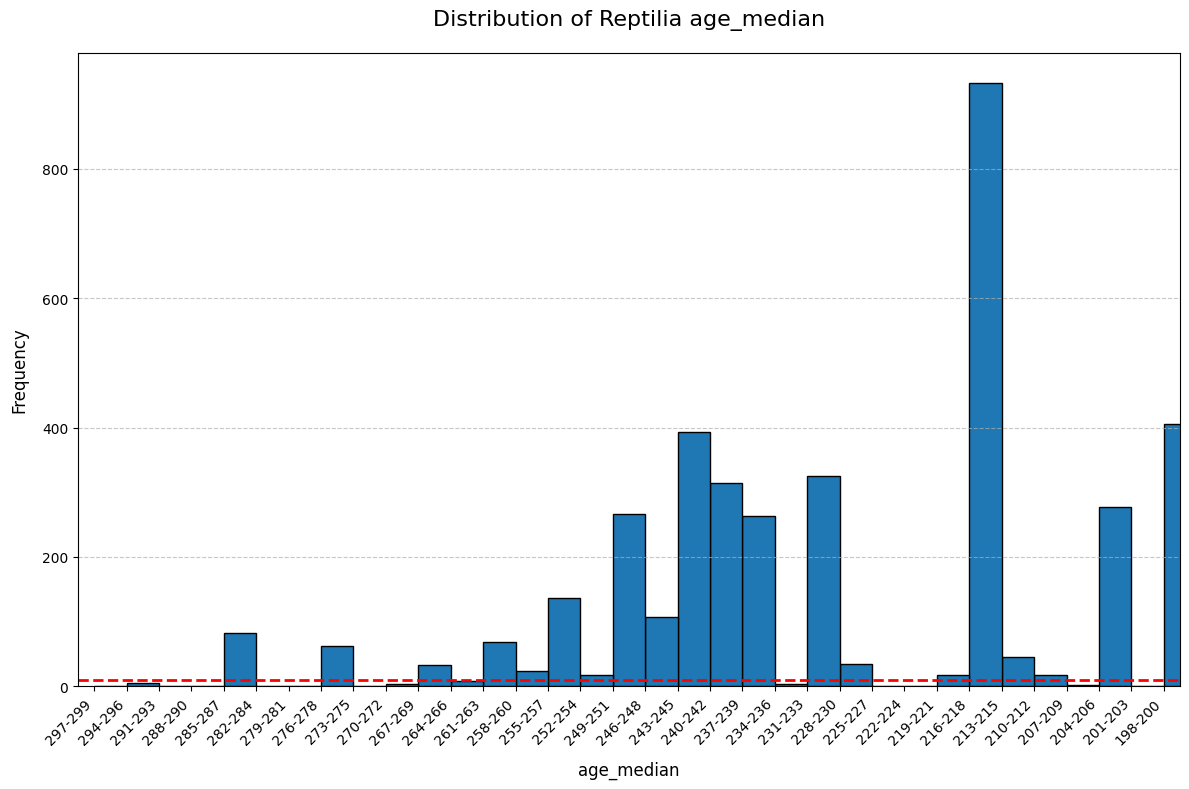

In [38]:
flexible_histogram(reptilia2, 'Reptilia', 'age_median', 3)

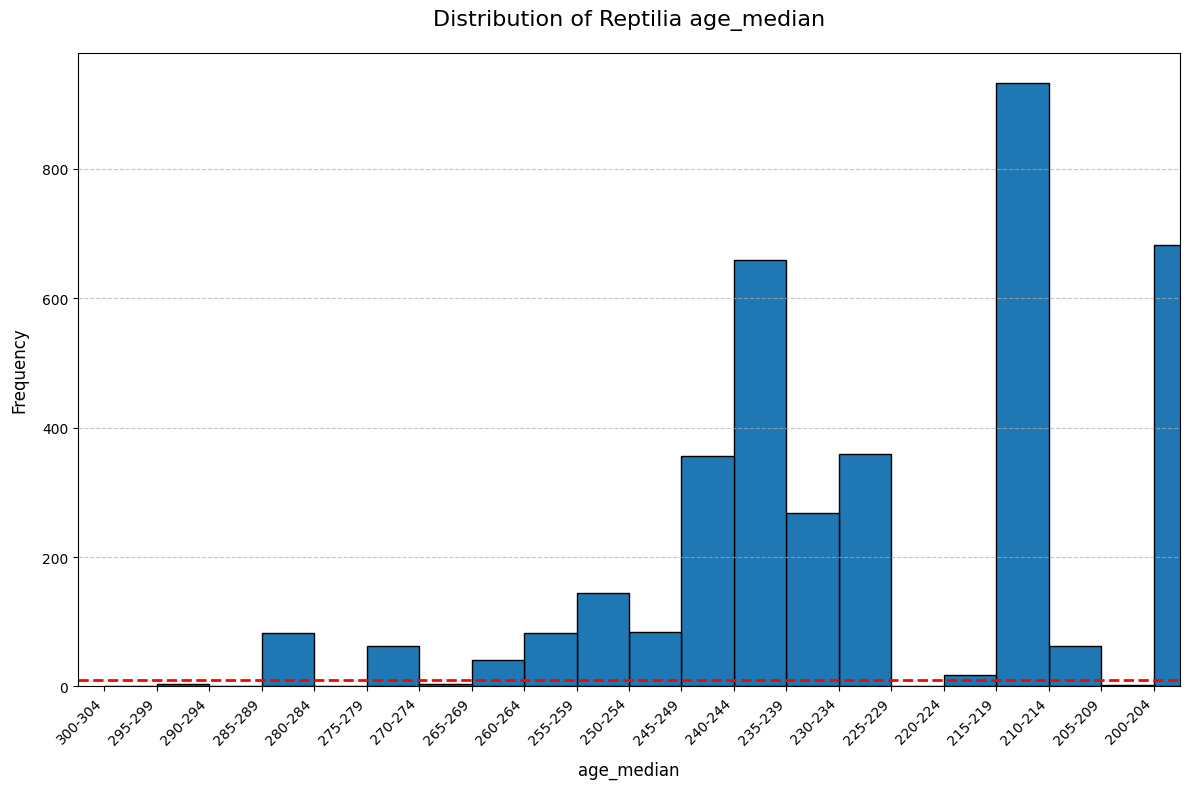

In [39]:
flexible_histogram(reptilia2, 'Reptilia', 'age_median', 5)

In [40]:
# Custom function to plot age RANGE (x) frequency (y) with log scale
def range_plot(df, df_name):
    # Count the frequency of each age range
    df['range'] = df.apply(lambda row: (row['age_min'], row['age_max']), axis=1)
    frequency = df['range'].value_counts().sort_index()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each range as a horizontal line with log-transformed y-values
    for (age_min, age_max), count in frequency.items():
        ax.plot([age_min, age_max], [np.log(count)] * 2, 'b-', linewidth=2)

    # Set the axis labels and title
    ax.set_xlabel('Age')
    ax.set_ylabel('Log(Frequency)')
    ax.set_title(f'{df_name} Age Range Frequency Plot (Log Scale)')

    # Get the x-axis limits
    x_min, x_max = ax.get_xlim()

    # Create ticks for every 1 unit
    ticks = np.arange(np.ceil(x_min), np.floor(x_max) + 1, 1)
    ax.set_xticks(ticks)

    # Create labels for every 5 units
    labels = [str(int(x)) if x % 5 == 0 else '' for x in ticks]
    ax.set_xticklabels(labels)

    # Invert the x-axis
    ax.invert_xaxis()

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add horizontal line at y=log(10)
    ax.axhline(y=np.log(10), color='r', linestyle='--', linewidth=2)

    # Customize y-axis ticks to show original frequency values
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{np.exp(y):.0f}' for y in y_ticks])

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'eda_images/{df_name}_age_range_plot_log.png', dpi=300)
    plt.show()
    plt.close()

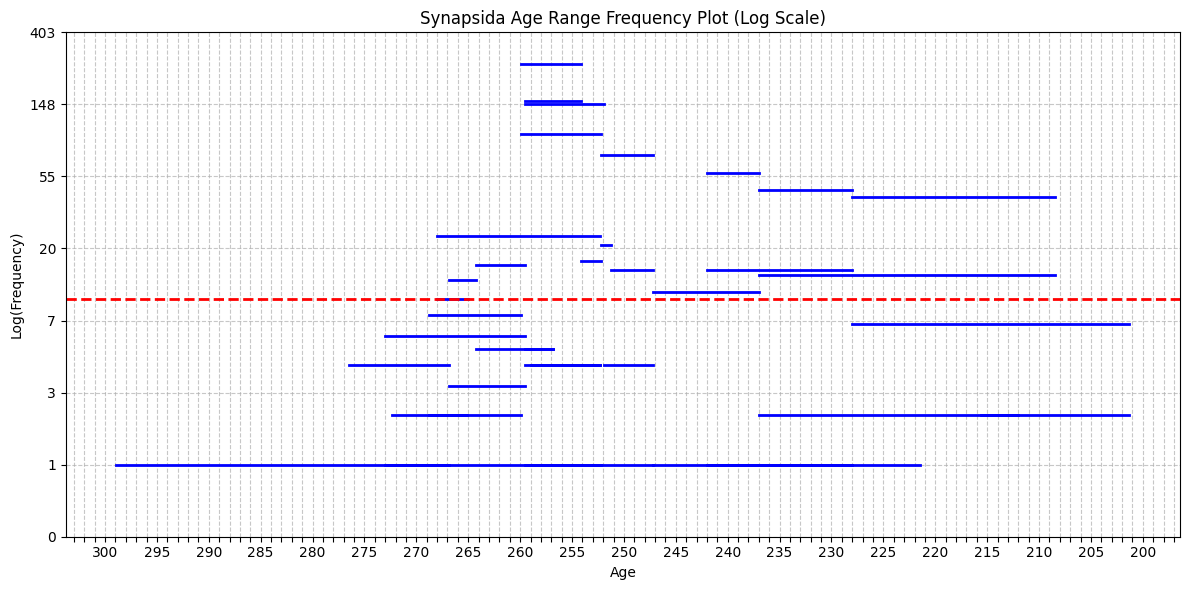

In [41]:
range_plot(synapsida2, 'Synapsida')

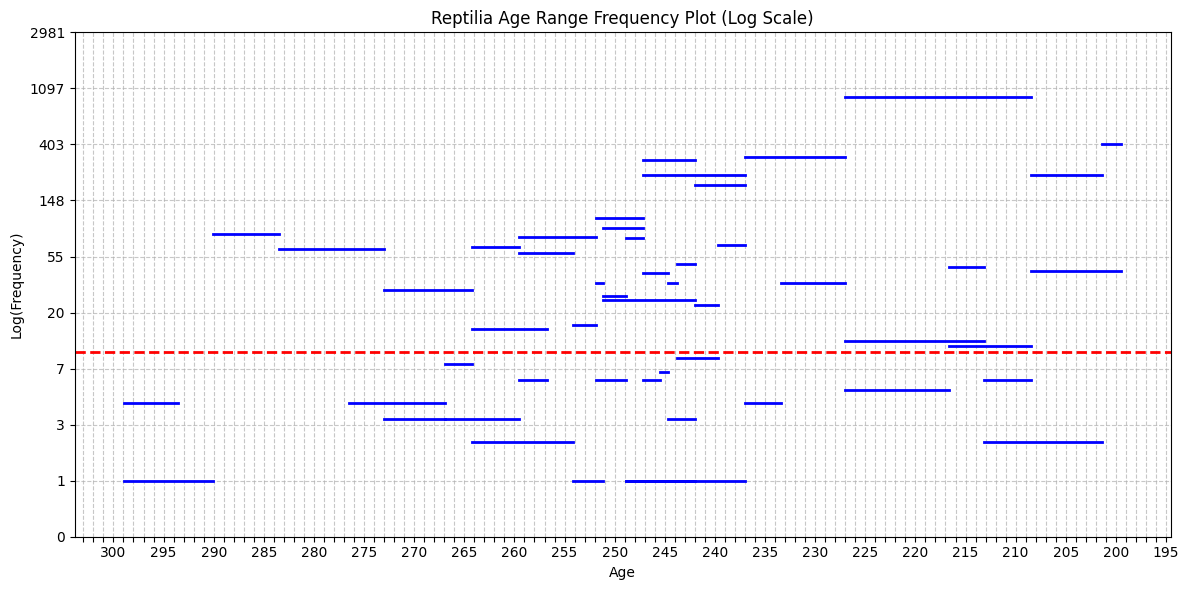

In [42]:
range_plot(reptilia2, 'Reptilia')